# PPO

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
device_name = "cpu"

if True:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cuda


## Process data

In [3]:
import sys
sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")
import flowdata
import flowenv

raw_data_train, raw_data_test = flowdata.flow_data.using_data()
print(raw_data_train)
# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/Flow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/Flow-v1", data=raw_data_test)

      Unnamed: 0.1  Unnamed: 0                                 Flow ID  \
0            38416         108  192.168.1.5-192.168.1.12-20003-57624-6   
1             2081         602   192.168.1.1-192.168.1.9-49367-20001-6   
2            19562         906  192.168.1.7-192.168.1.12-20003-59969-6   
3            40475          65   192.168.1.2-192.168.1.3-54139-20000-6   
4            40693          93                   8.0.6.4-8.6.0.1-0-0-0   
...            ...         ...                                     ...   
5121         40546         136   192.168.1.2-192.168.1.3-54139-20000-6   
5122         40811          33                   8.0.6.4-8.6.0.1-0-0-0   
5123         40758         158   192.168.1.2-192.168.1.4-48948-20000-6   
5124         40481          71   192.168.1.2-192.168.1.3-54139-20000-6   
5125         39398         147  192.168.1.5-192.168.1.12-20003-57624-6   

            Src IP  Src Port       Dst IP  Dst Port  Protocol  \
0     192.168.1.12     57624  192.168.1.5     

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Plot rewards

In [5]:
def plot_rewards(rewards: list, show_result=False):
    plt.figure(1)
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

## Network

In [ ]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(ActorCriticNetwork, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
        )
        self.actor = nn.Sequential(
            nn.Linear(128, n_outputs),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        common_out = self.common(x)
        action_probs = self.actor(common_out)
        state_value = self.critic(common_out)
        return action_probs, state_value

## Constants

In [ ]:
LR = 1e-4
GAMMA = 0.99
EPSILON = 0.2
BATCH_SIZE = 64

## Variables

In [ ]:
# TODO: change network
num_episodes = 1000

n_inputs = train_env.observation_space.shape[0]
n_outputs = train_env.action_space.n

policy_net = ActorCriticNetwork(n_inputs, n_outputs).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
steps_done = 0

memory = ReplayMemory(int(1e6))
episode_rewards = []

## Functions

In [ ]:
# TODO: return policy_net
def select_action(state: torch.Tensor):
    prob_distribution = policy_net(state)
    action = torch.multinomial(prob_distribution, 1)
    return action

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transitions))

    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)

    G = 0
    returns = []

    for r in torch.flip(rewards, dims=[0]):
        G = r + GAMMA * G
        returns.insert(0, G)

    returns = torch.tensor(returns, device=device, dtype=torch.float32)

    old_probs = policy_net(states).gather(1, actions).detach()

    for _ in range(5):
        new_props = policy_net(states).gather(1, actions)
        ratio = new_props / old_probs

        advantages = returns - returns.mean()

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - EPSILON, 1 + EPSILON) * advantages
        loss = -torch.min(surr1, surr2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## Main loop

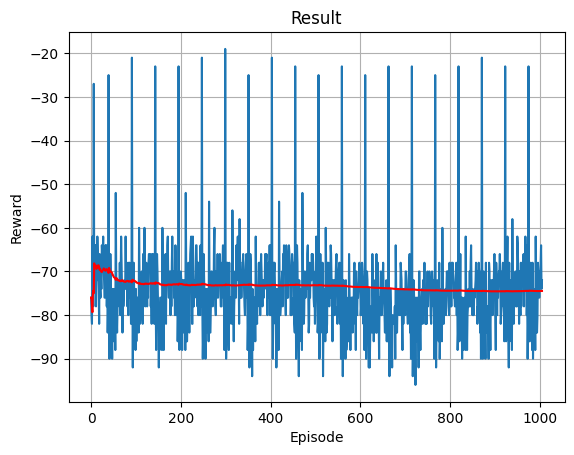

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
for i_episode in range(num_episodes):
    # Initialize the environment and state
    sum_reward = 0

    initial_state, info = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        # select action
        action = select_action(state)

        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())

        # to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item()

        # move to the next state
        state = next_state

        # optimize the model
        optimize_model()

        if terminated:
            break

    # do after the episode
    episode_rewards.append(sum_reward)
    if i_episode > 0 and i_episode % 10 == 0:
        plot_rewards(episode_rewards)

# complete the episode
plot_rewards(episode_rewards, show_result=True)
torch.save(policy_net.state_dict(), "ppo_no2.pth")  # save the model

train_env.close()

## Test the model

In [ ]:
MODEL_PATH = "ppo_no2.pth"

# TODO: load the model
# load the model
trained_network = ActorCriticNetwork(n_inputs, n_outputs).to(device)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

for i_loop in range(100):
    test_raw_state, _ = test_env.reset()
    test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        with torch.no_grad():
            test_action = trained_network(test_state).max(1).indices.view(1, 1)

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        index = test_info["confusion_position"]
        confusion_array[index[0], index[1]] += 1

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[0, 0]
    tn = confusion_array[1, 1]
    fp = confusion_array[0, 1]
    fn = confusion_array[1, 0]

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)

    if i_loop % 10 == 0:
        plot_metrics(metrics_dictionary)

# plot metrics
plot_metrics(metrics_dictionary, show_result=True)